# Simple MCMC algorithm (Metropolis-Hastings) using differential evolution jumps

In [1]:
# import useful libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import corner

## Make fake data

Consider a signal described by a sine wave of three parameters: amplitude $A$, frequency $f$, and phase $\phi$.

\begin{equation}
h(t) = A\sin{(2\pi ft-\phi)}
\end{equation}

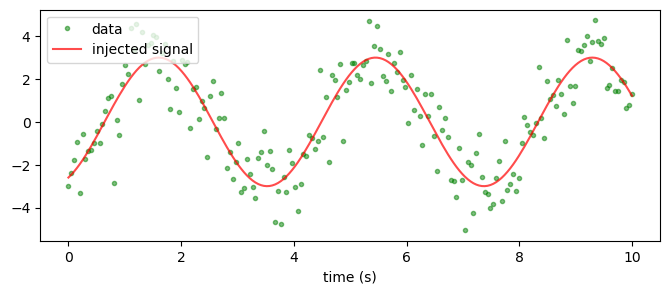

In [2]:
# first make time-series, over which data is collected
times = np.linspace(0, 10, 200)
n = len(times)

# define injected parameters which describe the signal
amp_inj = 3.
freq_inj = 0.26
phase_inj = np.pi / 3.

# for convenience later, store information about parameters
params_inj = [amp_inj, freq_inj, phase_inj]
num_params = len(params_inj)
param_labels = ['amplitude', 'frequency', 'phase']
param_colors = ['blue', 'green', 'orange']

# make injected signal
def get_signal(params):
    # unpack parameters
    amp, freq, phase = params
    signal = amp * np.sin(2*np.pi*freq*times - phase)
    return signal

signal_inj = get_signal(params_inj)

# add some Gaussian noise
sigma = 1.  # standard deviation of noise
noise = np.random.normal(loc=0., scale=sigma, size=n)

# make and plot data
data = signal_inj + noise

plt.figure(figsize=(8,3))
plt.plot(times, data, 'g.', alpha=0.5, label='data')
plt.plot(times, signal_inj, color='red', alpha=0.7, label='injected signal')
plt.xlabel('time (s)')
plt.legend(loc='upper left')
plt.show();

In [3]:
# define the domain of the parameters
# param_mins = [amp_min, freq_min, phase_min]
# param_maxs = [amp_max, freq_max, phase_max]
param_mins = [0.5, 0.01, 0.]
param_maxs = [5., 5., 2.*np.pi]

# function tells whether given parameters are in domain
def in_domain(params):
    in_dom = True
    for i in range(num_params):
        if params[i] < param_mins[i] or params[i] > param_maxs[i]:
            in_dom = False
            continue
    return in_dom

## Construct the likelihood function

The log-likelihood is proportional to the noise weighted inner product of the difference of the data and the signal with itself.

\begin{equation}
\ln{\mathcal{L}} = -\frac{1}{2}(d-h|d-h)
\end{equation}

The noise weighted inner product between two time series, $a$ and $b$, is defined

\begin{equation}
(a|b) = \sum_i \frac{a_ib_i}{\sigma^2}
\end{equation}

In [4]:
# define the inner product
# input arrays (with piecewise multiplication)
def inner_product(a, b):
    return sum(a * b) / sigma**2

In [5]:
# the likelihood depends on the parameter values of the chain
def get_lnlike(params):
    # first make sure parameters are in allowed domain
    if not in_domain(params):
        return -np.inf
    else:
        # make signal at these parameter values
        signal = get_signal(params)
        # evaluate likelihoood
        lnlike = (-1/2) * inner_product(data - signal, data - signal)
        return lnlike

## Plot cross-sections of likelihood
This is a good check that our formulation of the likelihood is correct.

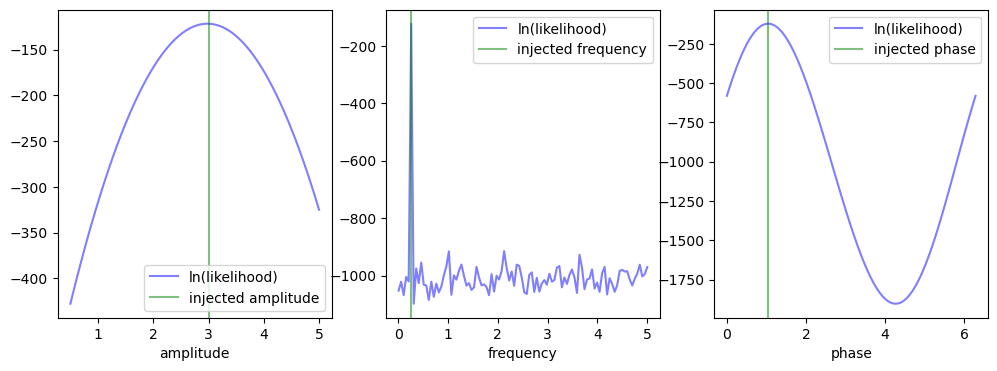

In [15]:
# plot log-likelihood as function of parameter value
# other parameters fixed at injected value
# good way to check maximum likelihood is at injected parameters


plt.figure(figsize=(12,4))

for i in range(num_params):
    # how many likelihood evaluations in cross-section
    num_pts = 100
    # coordinates in cross-section
    param_vals = np.linspace(param_mins[i], param_maxs[i], num_pts)
    # initialize array to store likelihood values
    likelihood_vals = np.zeros(num_pts)
    params = params_inj.copy()

    # get likelihood values through cross-section
    for j in range(num_pts):
        params[i] = param_vals[j]
        likelihood_vals[j] = get_lnlike(params)
    
    
    plt.subplot(1, num_params, i+1)
    plt.plot(param_vals, likelihood_vals, color='blue', alpha=0.5, label='ln(likelihood)')
    plt.axvline(params_inj[i], color='green', alpha=0.5, label='injected ' + param_labels[i])
    plt.xlabel(param_labels[i])
    plt.legend();

## Differential evolution jump proposals

A common jump proposal is differential evolution (DE). DE requires a history of samples to make jump proposals. At the $i^\text{th}$ iteration, the jump proposal, $\vec{J}$, is proportional to the difference between two randomly chosen samples from the history, $\vec{x}_a$ and $\vec{x}_b$. 

\begin{equation}
\vec{J} = \gamma \times (\vec{x}_a - \vec{x}_b)
\end{equation}

where $\gamma$ is a scalar weighting drawn from a Gaussian with standard deviation $2.38/\sqrt{2D}$ and $D$ is the number of parameters in the model. Initially the history is populated with uniform draws in the parameters' domain, and elements of the (adaptive) history are replaced with newly accepted samples.

DE is one of many possible jump proposals. Other proposals include those generated by a Fisher information matrix, draws from a prior or Gaussian distribution, and many more! Efficient MCMC algorithms use a blend of various jump proposals. This example has a simple likelihood of low dimension, so we can effectively sample using only DE.

## Do MCMC

In [16]:
# Metropolis-Hastings algorithm to sample likelihood using differential evolution jumps

def MCMC(num_samples):
    
    # initialize samples and likelihood values
    samples = np.zeros((num_samples, num_params))
    lnlikes = np.zeros(num_samples)
    
    # draw first sample
    samples[0] = [np.random.uniform(param_mins[i], param_maxs[i]) for i in range(num_params)]
    lnlikes[0] = get_lnlike(samples[0])
    
    # initialize counters to track jump acceptance fraction
    accept_count = 0
    reject_count = 0
    
    # initialize a history to use with differential evolution jumps
    len_history = 1000
    history = np.array([np.random.uniform(param_mins[i], param_maxs[i], size=len_history) for i in range(num_params)]).T
    # it's quicker to generate the random numbers used to select elements of the history and weights all at once
    choices1 = np.random.choice(len_history, size=num_samples)
    choices2 = np.random.choice(len_history, size=num_samples)
    weights = np.random.normal(loc=0., scale=2.38/np.sqrt(2*num_params), size=num_samples)
    
    
    # main MCMC loop
    for i in range(num_samples - 1):
        
        # update progress every 10%
        if i % (num_samples // 10) == 0:
            print(i)
        
        # get a jump proposal using differential evolution
        jump = (history[choices1[i]] - history[choices2[i]]) * weights[i]
        new_point = samples[i] + jump
        new_lnlike = get_lnlike(new_point)
        
        # compute acceptance ratio
        acc_ratio = np.exp(new_lnlike - lnlikes[i])
        
        # decide to accept or reject jump proposal
        random_uniform_draw = np.random.uniform()  # get random number in [0, 1]
        if random_uniform_draw < acc_ratio:  # accept
            accept_count += 1
            samples[i+1] = history[i%len_history] = new_point
            lnlikes[i+1] = new_lnlike
        if random_uniform_draw >= acc_ratio:  # reject
            reject_count += 1
            samples[i+1] = samples[i]
            lnlikes[i+1] = lnlikes[i]
            
    # compute jump acceptance fraction
    acc_frac = accept_count / (accept_count + reject_count)
    
    return samples, lnlikes, acc_frac

In [8]:
# do MCMC!
# this may take a few minutes
num_samples = int(1e6)
samples, lnlikes, acc_frac = MCMC(num_samples)
print('\n' + 'complete.')

0
100000
200000
300000
400000
500000
600000
700000
800000
900000

complete.


## Post-Processing

In [9]:
print('acceptance fraction = ' + str(acc_frac))

acceptance fraction = 0.47863247863247865


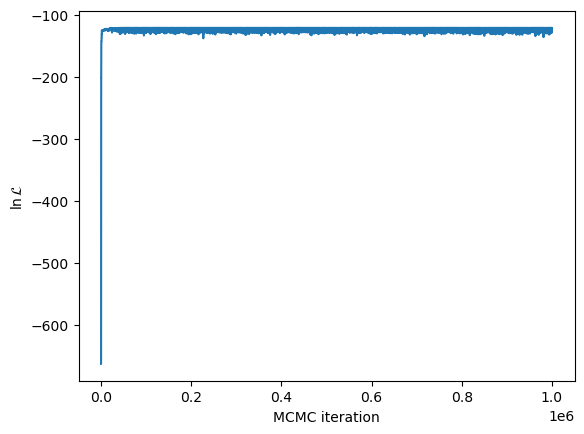

In [10]:
# plot the likelihood as a function of MCMC iteration
plt.plot(lnlikes)
plt.xlabel('MCMC iteration')
plt.ylabel(r'$\ln{\mathcal{L}}$');

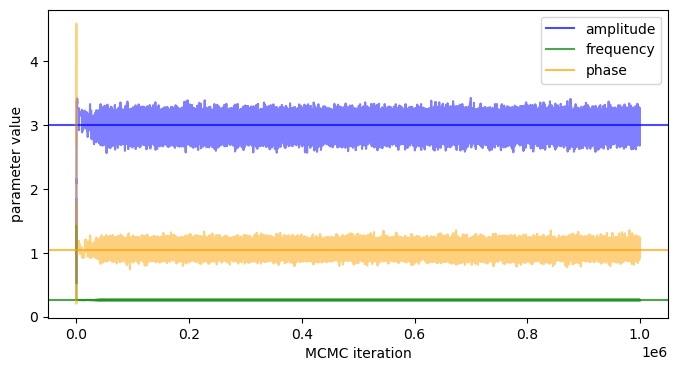

In [11]:
# make trace plot
# shows the trajectory of the chain through parameter space
plt.figure(figsize=(8,4))

for i in range(num_params):
    plt.axhline(params_inj[i], color=param_colors[i], alpha=0.7, label=param_labels[i])
    plt.plot(samples[:,i], color=param_colors[i], alpha=0.5)

plt.xlabel('MCMC iteration')
plt.ylabel('parameter value')
plt.legend(loc='upper right')
plt.show();

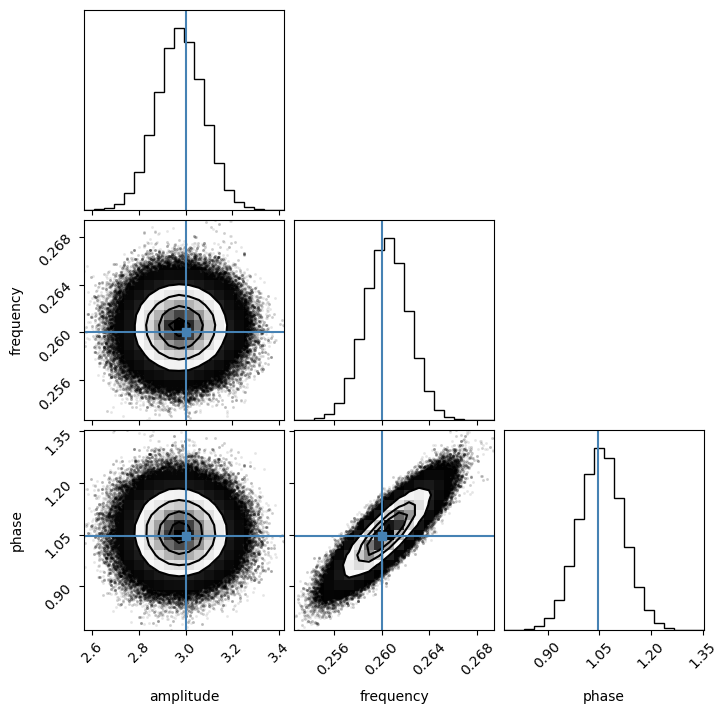

In [12]:
# make corner plot
# bins and plots cross-sections of the samples
burnin = int(num_samples / 10)
fig = corner.corner(samples[burnin:], truths=params_inj, labels=param_labels, ranges=[0.99]*num_params)

In [13]:
# get the maximum a posteriori (MAP) parameters

# draw samples within neighborhood of maximum likelihood
num_draws = 100
draws = np.zeros((num_draws, num_params))
# only accept draws that have log-likelihood above threshold
threshold = max(lnlikes) - 2
count = 0
while count < num_draws:
    draw_index = np.random.choice(range(burnin, num_samples))
    if lnlikes[draw_index] > threshold:
        draws[count] = samples[draw_index]
        count += 1

# MAP parameters are the mean of these samples in the neighborhood of the maximum likelihood
params_MAP = np.mean(draws, axis=0)

# print injected and MAP parameters and their difference
print('injected parameters: ' + str(params_inj))
print('MAP parameters: ' + str(params_MAP))
print('parameter errors: ' + str(abs(params_inj - params_MAP)))

injected parameters: [3.0, 0.26, 1.0471975511965976]
MAP parameters: [2.98560412 0.26032543 1.05674996]
parameter errors: [0.01439588 0.00032543 0.00955241]


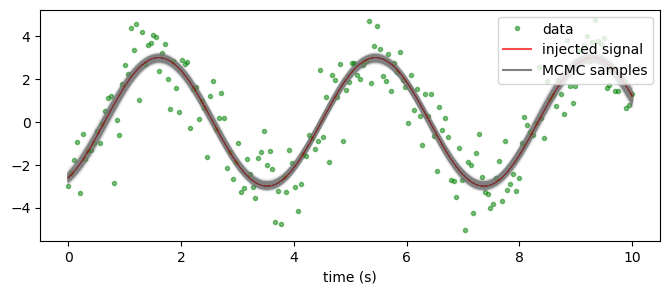

In [17]:
# make a Bayesogram
# superposes the signals generated by random draws from the samples

plt.figure(figsize=(8,3))

# number of draws from the samples
num_draws = 1000
# get random indices for draws
draw_indices = np.random.choice(range(burnin, num_samples), size=num_draws)
# get signals corresponding to these draws
signals = [get_signal(samples[draw_index]) for draw_index in draw_indices]

# plot data, injected signal, and signals from sample draws
plt.plot(times, data, 'g.', label='data', alpha=0.5)
plt.plot(times, signal_inj, color='red', alpha=0.8)
[plt.plot(times, signals[i], color='grey', alpha=10/num_draws) for i in range(num_draws)]

# make entries for legend
green_dot = mlines.Line2D([], [], color='green', marker='o', markersize=3, alpha=0.5, label='data', ls='')
red_line = mlines.Line2D([], [], color='red', label='injected signal', alpha=0.7)
grey_line = mlines.Line2D([], [], color='grey', label='MCMC samples')
plt.legend(handles=[green_dot, red_line, grey_line], loc='upper right')
plt.xlabel('time (s)');